# Grid

A tutorial on grid classes, its properties and transformations.

### Content
* [Geometries](#Geometries)
* [Basic properties](#Basic-properties)
* [Grid transformations](#Grid-transformations)
    * [Minimal cube](#Minimal-cube)
    * [Rescale](#Rescale)
    * [Orthogonalization](#Orthogonalization)
    * [Corner-point representation](#Corner-point-representation)
    * [Local grid](#Local-grid)

## Geometries

Proceeding from the finite-difference simulation approach, spatial shape of the reservoir model is discretized into smaller parts called grid blocks (or cells).


### Orthogonal Grid

Grid describes the reservoir geometry (shape) and defines the blocks with which static and dynamic geological properties are associated.  If all cells are of the same parallelipiped shape and regular size we obtain the orthogonal grid. To specify such a grid one has to set a number of cells in each direction (nx, ny, nz) and cell sizes (dx, dy, dz).

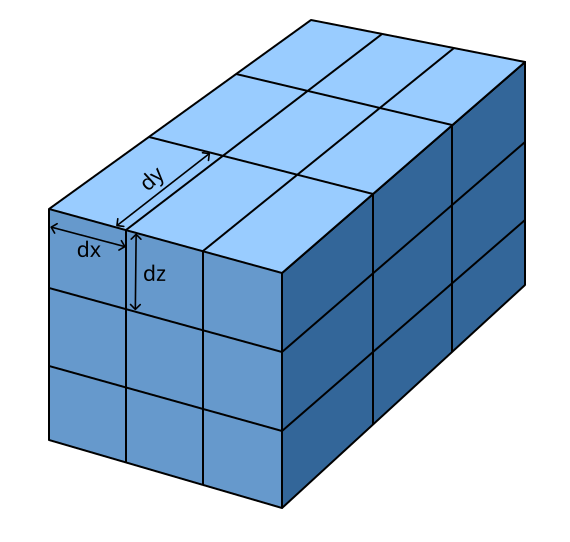



In `DeepField`, grids of this type are represented using the `OrthogonalGrid` class. In particular, Egg model has a orthogonal grid. Let's load the part of this model that only describes the grid (note that we specify the `config` parameter in the `load` method to load only the required keywords):

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield import Field
from deepfield.field.plot_utils import plot_bounds_3d, plot_bounds_2d

model = Field('../open_data/egg/Egg_Model_ECL.DATA').load()

INFO:Field:Using default config.
INFO:Field:Start reading ..\open_data\egg\RESULTS\Egg_Model_ECL\Egg_Model_ECL.EGRID
INFO:Field:Decoding GRIDHEAD.
INFO:Field:Decoding COORD.
INFO:Field:Decoding ZCORN.
INFO:Field:Decoding ACTNUM.
...
INFO:Field:Decoding WGNAMES.
INFO:Field:Finish reading ..\open_data\egg\RESULTS\Egg_Model_ECL\Egg_Model_ECL.SMSPEC
INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, DIMENS, ZCORN, COORD, ACTNUM, DX, DY, DZ, TOPS
INFO:Field:ROCK attributes: PORO, PERMX, PERMY, PERMZ, NTG
INFO:Field:STATES attributes: PRESSURE, SOIL, SWAT
INFO:Field:TABLES attributes: DENSITY, PVCDO, PVTW, ROCK, SWOF
INFO:Field:WELLS attributes: WCONPROD, WCONINJE, WELSPECS, RESULTS, WELLTRACK, COMPDAT
INFO:Field:FAULTS attributes: 
INFO:Field:AQUIFERS attributes: 
INFO:Field:=========================


In [2]:
type(model.grid)

deepfield.field.grids.OrthogonalGrid

`DIMENS` attribute defines the dimensionality of the grid.

In [3]:
model.grid.dimens

array([60, 60,  7])

Block sizes are contained in `DX`, `DY`, `DZ` attributes.

In [4]:
model.grid.dx.shape, model.grid.dx[0, 0, 0]

((60, 60, 7), 8.0)

`TOPS` define the depth of the upper cell bound.

In [5]:
model.grid.tops.shape, model.grid.tops[0, 0, 0]

((60, 60, 7), 4000.0)

### Corner-Point Grid 

Another option for defining the grid is corner point geometry. In this case, the grid is defined by setting the grid pillars and the position of the corner points of the blocks on these pillars.

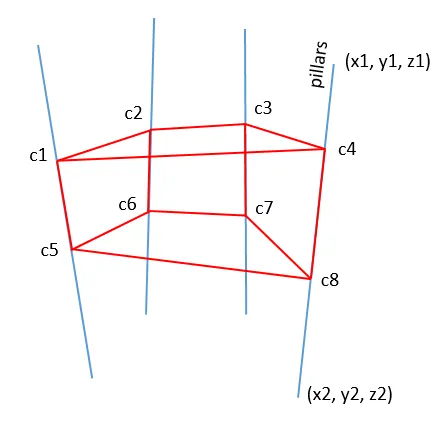

Corner point grid is specified in the Norne model. Let's load it:

In [6]:
model = Field(path='../open_data/norne/NORNE_ATW2013.DATA').load()

INFO:Field:Using default config.
INFO:Field:Start reading NORNE_ATW2013.DATA
INFO:Field:[NORNE_ATW2013.DATA:11] Loading DIMENS
INFO:Field:[NORNE_ATW2013.DATA:19] Loading OIL
...
INFO:Field:Finish reading BC0407_HIST01122006.SCH
INFO:Field:Finish reading NORNE_ATW2013.DATA
INFO:Field:MINPV 500.0 is applied.
                PVTG table is converted into PVDG one.
INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, DIMENS, COORD, ZCORN, ACTNUM, MINPV
INFO:Field:ROCK attributes: PORO, NTG, PERMX, PERMY, PERMZ, MULTZ, SWATINIT, SWL, SWCR, SGU, SGL, SGCR, SOWCR, SOGCR, SWU, ISWCR, ISGU, ISWL, ISWU, ISGL, ISOGCR, ISOWCR
INFO:Field:STATES attributes: 
INFO:Field:TABLES attributes: PVTO, ROCK, PVTW, DENSITY, SWOF, SGOF, RSVD, PVDG
INFO:Field:WELLS attributes: WCONPROD, WCONINJE, WELSPECS, WELLTRACK, COMPDAT
INFO:Field:FAULTS attributes: FAULTS, MULTFLT
INFO:Field:AQUIFERS attributes: 
INFO:Field:=========================


`DIMENS` contains model grid dimensionality

In [7]:
model.grid.dimens

array([ 46, 112,  22])

Coordinates of grid pillars are contained in COORD atributes. Each pillar is defined by 6 numbers, coordinates of 2 points ($x_1$, $y_1$, $z_1$) and
($x_2$, $y_2$, $z_2$). Totally $(n_x+1)\times(n_y+1)$ pillars are defined.

In [8]:
model.grid.coord.shape

(47, 113, 6)

$z$ coordinates of blocks are contained in ZCORN keyword. Each block is defined by it`s 8 corners.

In [9]:
model.grid.zcorn.shape

(46, 112, 22, 8)

## Basic properties

List of grid attributes

In [10]:
model.grid.attributes

('MAPAXES', 'DIMENS', 'COORD', 'ZCORN', 'ACTNUM', 'MINPV')

Grid dimensions

In [11]:
model.grid.dimens

array([ 46, 112,  22])

Active cells

In [12]:
model.grid.actnum.shape

(46, 112, 22)

Note, that grid data has the spatial form. Method `ravel` transforms specified attribute into a ravel shape as it is given in the source file (sometimes, this transformation is more complex than just `numpy.ravel` method applied to numpy arrays):

In [13]:
zcorn_raveled = model.grid.ravel('zcorn')

zcorn_raveled.shape, np.all(zcorn_raveled == model.grid.zcorn.ravel())

((906752,), False)

Grid location with respect to map coordinates and unit vectors in x and y grid directions can be obtained as follows:

In [14]:
model.grid.origin, model.grid.ex, model.grid.ey

(array([   0.   ,    0.   , 3037.473]), array([1., 0.]), array([0., 1.]))

Attribute `cell_centroinds` gives coordinates of cell centres. Let's get a center of the first cell:

In [15]:
model.grid.cell_centroids[0, 0, 0]

array([4.53215789e+05, 7.32000899e+06, 3.04003163e+03])

Each cell is defined by 8 corners and property `xyz` contains the coordinates. For example, coordinates of the first cell are

In [16]:
model.grid.xyz[0, 0, 0]

array([[4.53114000e+05, 7.31992100e+06, 3.03747300e+03],
       [4.53155031e+05, 7.31984000e+06, 2.98393300e+03],
       [4.53273188e+05, 7.32018000e+06, 3.06804500e+03],
       [4.53321312e+05, 7.32009450e+06, 3.06213000e+03],
       [4.53114000e+05, 7.31992100e+06, 3.03953100e+03],
       [4.53154622e+05, 7.31984080e+06, 2.99024100e+03],
       [4.53273099e+05, 7.32017984e+06, 3.07218800e+03],
       [4.53321063e+05, 7.32009481e+06, 3.06671200e+03]])

Propetry `cell_volumes` provides cell volumes, e.g. for the first cell we have

In [17]:
model.grid.cell_volumes[0, 0, 0]

112955.00136545351

Next we consider grid transformations.

## Grid transformations

### Minimal cube

Quite often active cells occupy only a small region within a grid. It might be useful to crop mininal region that contains active cells. The most simple way is to apply `crop_minimal_active_cube`. It finds minimal slices that contain active cells. The output grid has smaller dimensions:

In [18]:
min_grid, min_slices = model.grid.crop_minimal_cube()
min_grid.dimens, min_slices

((36, 92, 22), (slice(5, 41, None), slice(10, 102, None), slice(0, 22, None)))

In [19]:
min_grid.dimens

(36, 92, 22)

### Rescale

Orthogonal grids can be upscaled and downscaled, for corner point grids only upscaling is well defined. Parameter `factors` specifices scaling factor along each axis. Additional parameter `actnum_upscale` specifies how to transfer active cell into the new grid:

In [20]:
up_grid = model.grid.upscale(factors=(4, 4, 5), actnum_upscale='vote')
print('Original:', model.grid.dimens, 'Upscaled:', up_grid.dimens)

Original: [ 46 112  22] Upscaled: [11 28  4]


Dowscaling is implmented for orthogonal grids only.

### Orthogonalization

Corner point grid can be orthogonalized with respect to the bounding box of the corner point grid:

In [21]:
model.grid.bounding_box

array([[4.53114000e+05, 7.31583550e+06, 2.23026000e+03],
       [4.65658625e+05, 7.33111950e+06, 3.50841300e+03]])

Create a new orthogonal grid:

In [22]:
ort_grid = model.grid.orthogonalize(dimens=(10, 12, 14))
ort_grid.dimens

(10, 12, 14)

Note that grid origin coincides with the bounding box corner:

In [23]:
ort_grid.origin == model.grid.bounding_box[0]

array([ True,  True,  True])

### Corner-point representation

Orthoronal grid has a natural corner-point representation:

In [24]:
ort_grid.as_corner_point.attributes

('DIMENS', 'MAPAXES', 'ACTNUM', 'ZCORN', 'COORD')

A new instance can be obtained as

In [25]:
ort_grid.to_corner_point()

### Local grid

Local grid is a corner point grid that is bounded by upper and lower active cell surfaces and splits the space between in a given number of layers. This can be useful to get a grid with reduced number of inactive cells. The only parameter required is a target resolution along z-axis:

In [26]:
grid, grid_mask, z_top, z_bottom = model.grid.crop_minimal_grid(nz=10)
print("Local grid dimens:", grid.dimens)

Local grid dimens: (46, 112, 10)


Next figure shows top and bottom bounds of the local grid

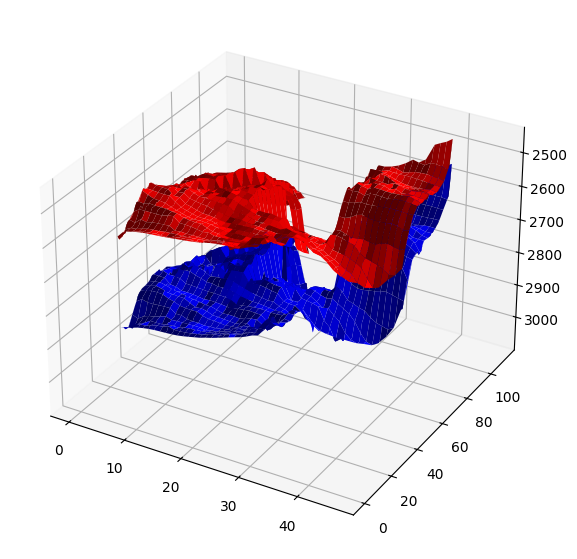

In [27]:
plot_bounds_3d(z_top, z_bottom, figsize=(9, 7))

The same bounds in 2d projections (to active an interactive mode set `x=None` and `y=None`):

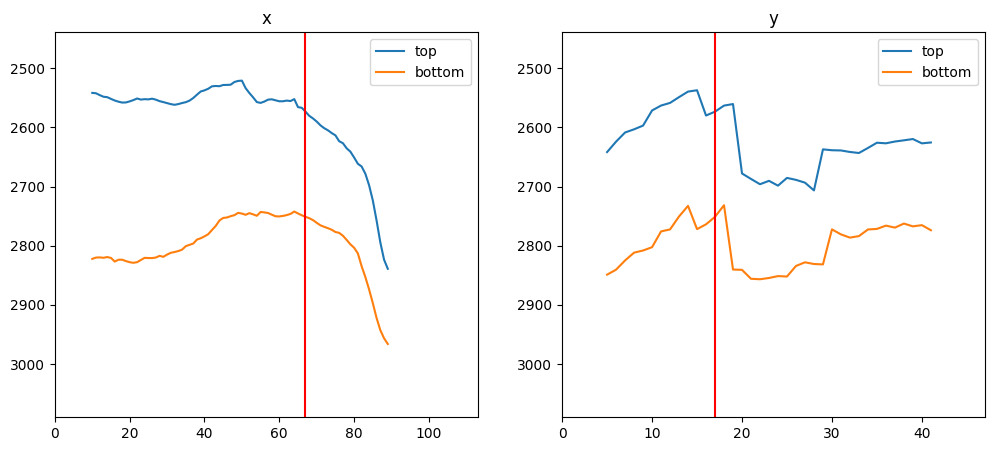

In [28]:
plot_bounds_2d(z_top, z_bottom, x=17, y=67, figsize=(12, 5))

At this point we finish the story about the `Grid` class and invite you to the next tutorials. In this tutorial we discussed various grid transformations. After gridd transformation one usually requires to map static and dynamic spatial parameters of the model to a new grid, this topic is covered in the tutorial [Properties_transfer](./09.Properties_transfer.ipynb) .